In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import seaborn

from dask.diagnostics import ProgressBar

nyc_data = dd.read_parquet("nyc_final")

In [2]:
with ProgressBar():
    citations_and_temps = nyc_data[nyc_data.index.to_series() < 201707] \
        .groupby("Citation Issued Month Year") \
        .agg({"Summons Number": "count", "Temp": "mean"}) \
        .persist()

[########################################] | 100% Completed | 79.01 s


(0.0, 81.965)

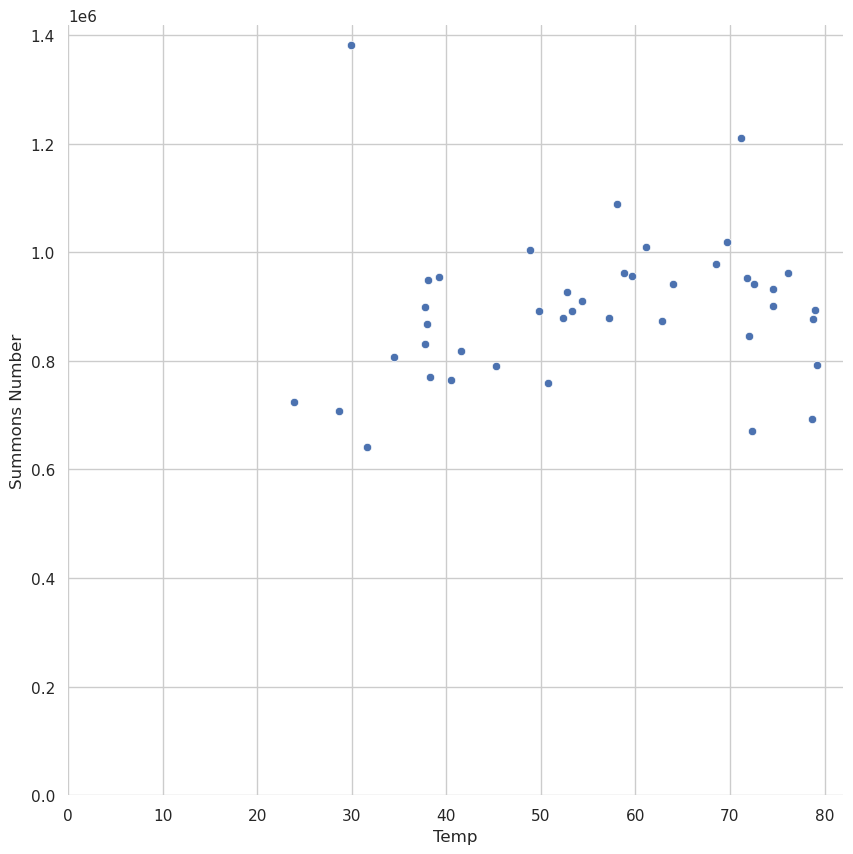

In [3]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)

seaborn.scatterplot(x="Temp", y="Summons Number", data=citations_and_temps.compute(), ax=ax)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

(0.0, 81.965)

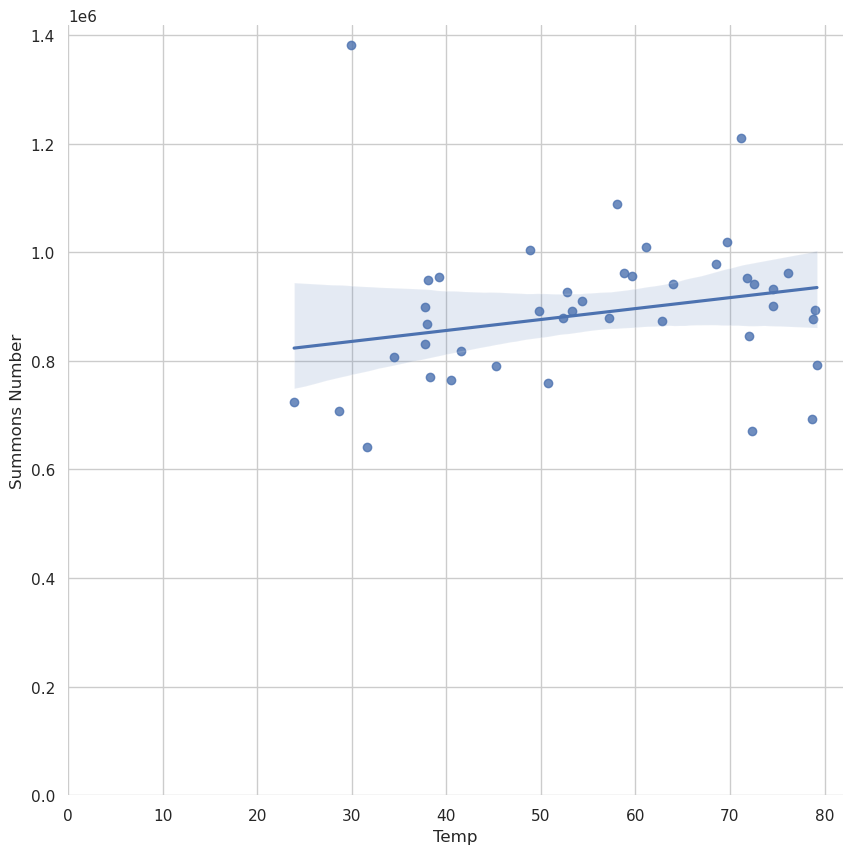

In [4]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)

seaborn.regplot(x="Temp", y="Summons Number", data=citations_and_temps.compute(), ax=ax, robust=True)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

(0.0, 81.965)

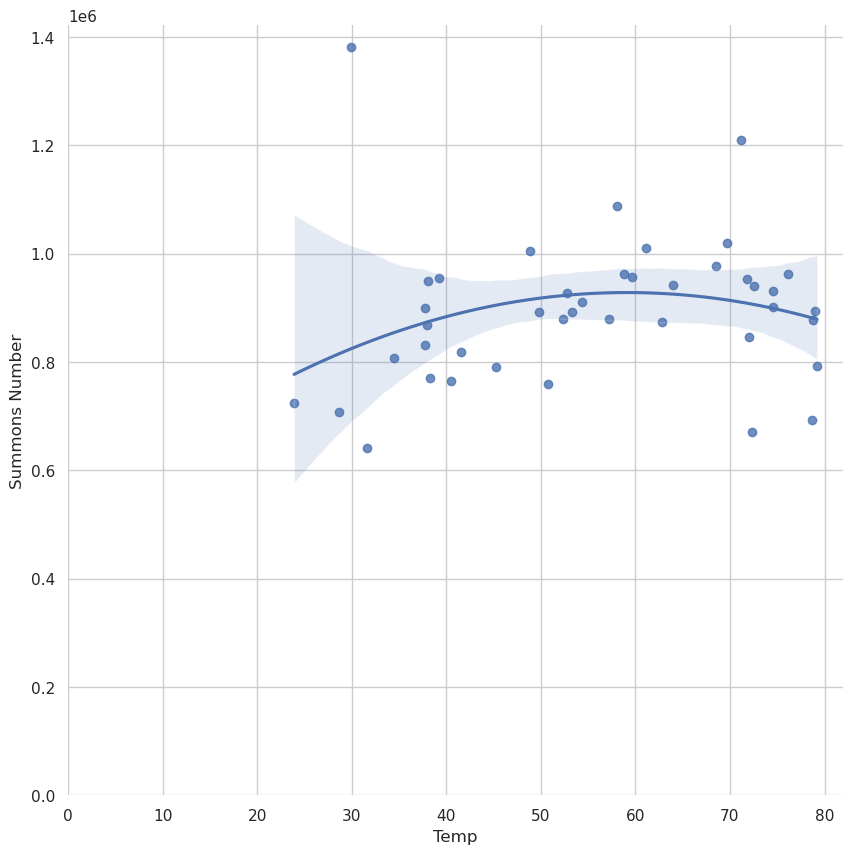

In [5]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)

seaborn.regplot(x="Temp", y="Summons Number", data=citations_and_temps.compute(), ax=ax, order=2)
plt.ylim(ymin=0)
plt.xlim(xmin=0)

In [6]:
nyc_data_withVehicleAge = dd.read_parquet("nyc_data_vehicleAge")

color_filter = ["BLACK", "WHITE", "GREY", "RED", "GREEN", "BLUE"]
row_filter = nyc_data_withVehicleAge["Vehicle Color"].isin(color_filter)
column_filter = ["Vehicle Age", "Vehicle Color"]

ages_and_colors = nyc_data_withVehicleAge[row_filter][column_filter].persist()
ages_and_colors.memory_usage().compute()

Index            39776680
Vehicle Age      39776680
Vehicle Color    39776680
dtype: int64

In [7]:
with ProgressBar():
    print(ages_and_colors.count().compute())

[########################################] | 100% Completed | 1.26 sms
Vehicle Age      4972085
Vehicle Color    4972085
dtype: int64


[########################################] | 100% Completed | 102.27 ms


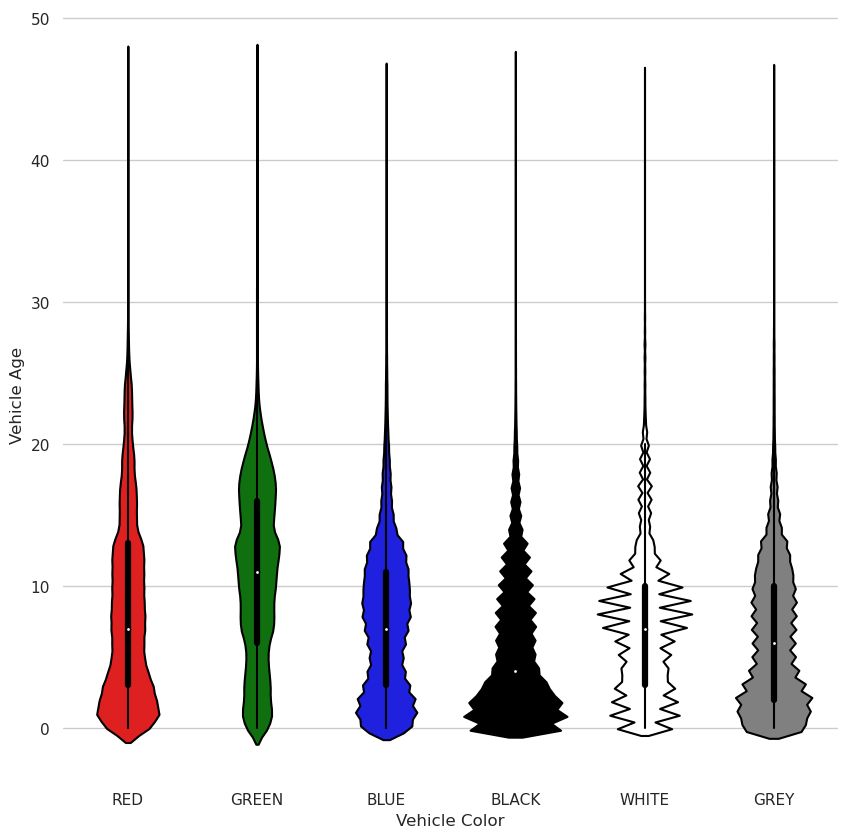

In [8]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)

group_order = ["RED", "GREEN", "BLUE", "BLACK", "WHITE", "GREY"]

with ProgressBar():
    seaborn.violinplot(
        x="Vehicle Color",
        y="Vehicle Age",
        data=ages_and_colors.compute(),
        order=group_order,
        palette=group_order,
        ax=ax,
    )

[########################################] | 100% Completed | 337.00 ms


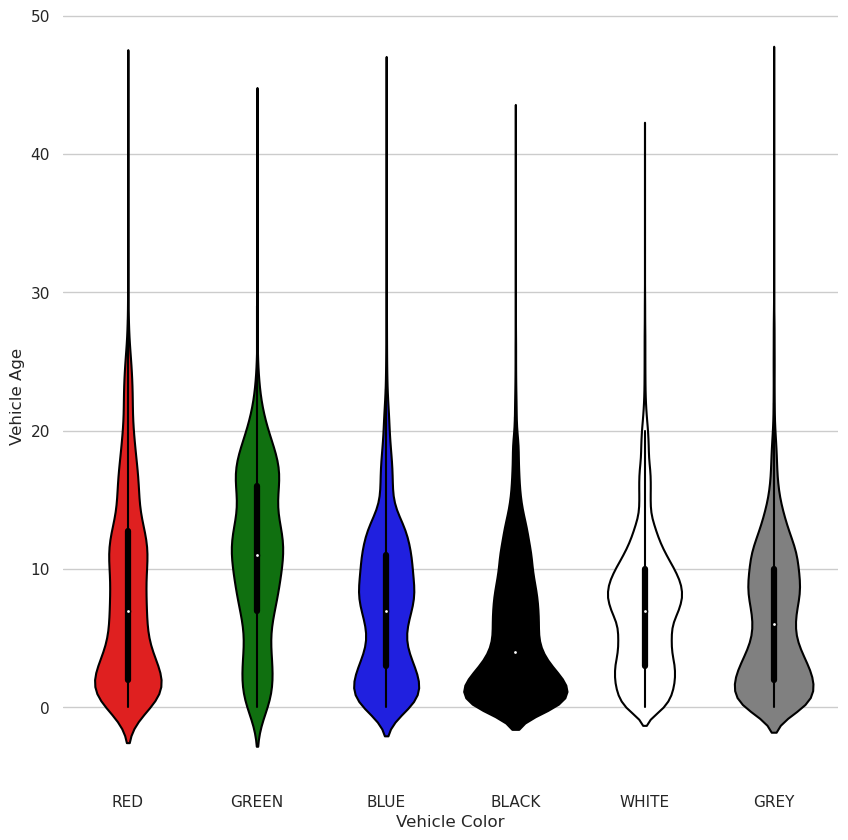

In [9]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10,10))
seaborn.despine(f, left=True, bottom=True)

sample = ages_and_colors.sample(frac=0.01)

with ProgressBar():
    seaborn.violinplot(
        x="Vehicle Color",
        y="Vehicle Age",
        data=sample.compute(),
        order=group_order,
        palette=group_order,
        ax=ax,
    )

In [10]:
from datetime import datetime

nyc_data_filtered = nyc_data[nyc_data["Issue Date"] < datetime(2017,1,1)]
day_of_the_week = nyc_data["Issue Date"].dt.strftime("%A")
month_of_the_year = nyc_data["Issue Date"].dt.strftime("%B")

nyc_data_with_dates_raw = nyc_data \
    .assign(DayOfWeek = day_of_the_week) \
    .assign(MonthOfYear = month_of_the_year)

column_map = {"DayOfWeek": "Day of Week", "MonthOfYear": "Month of Year"}

nyc_data_with_dates = nyc_data_with_dates_raw.rename(columns=column_map)

In [11]:
with ProgressBar():
    summons_by_mydw = nyc_data_with_dates \
        .groupby(["Day of Week", "Month of Year"])["Summons Number"] \
        .count() \
        .compute()

[########################################] | 100% Completed | 325.17 s


In [15]:
heatmap_data = summons_by_mydw \
    .reset_index() \
    .pivot(index="Month of Year", columns="Day of Week", values="Summons Number")

heatmap_data

Day of Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Month of Year,,,,,,,
April,607152,545156,402261,149825,630984,614926,611033
August,442900,440458,274704,120220,438231,453051,419911
December,379545,370820,206421,93410,411955,435400,397735
February,488382,479349,328338,129467,519351,554489,516503
January,718696,541782,399772,148489,743184,604368,609042
July,410527,357636,241392,107167,505157,455322,454312
June,632474,646881,357258,145515,629538,686358,569228
March,596516,643091,387456,160498,691491,683058,646376
May,672771,555849,394592,147323,663021,724219,643288


<Axes: xlabel='Day of Week', ylabel='Month of Year'>

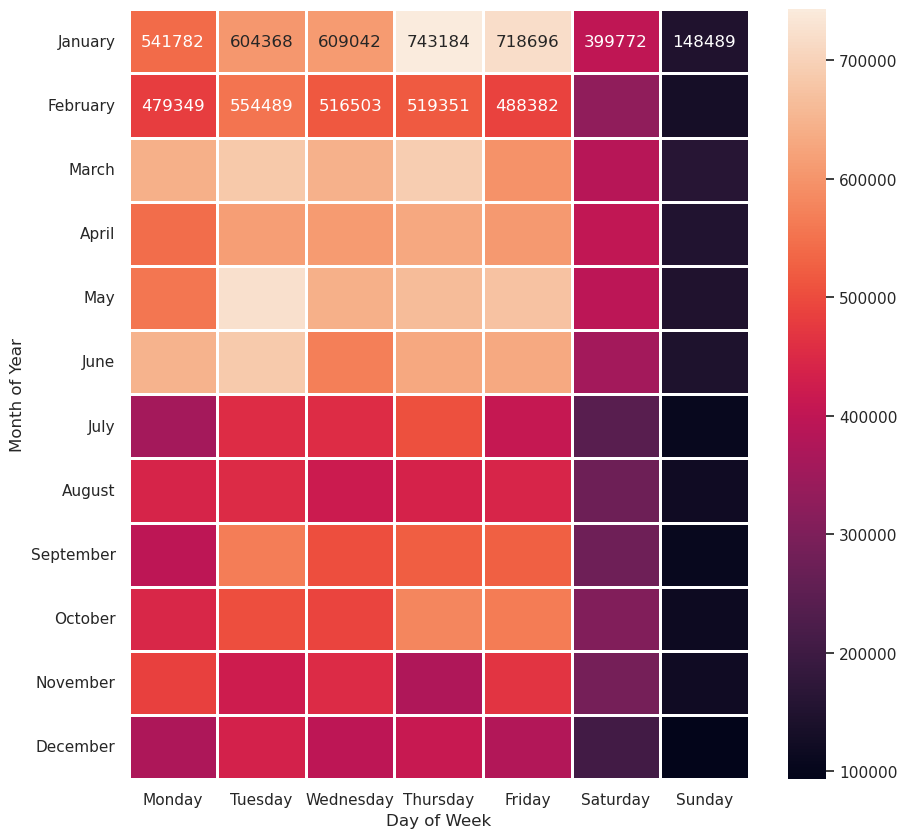

In [14]:
import calendar

months = calendar.month_name[1:]
weekdays = calendar.day_name[:]

f, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(heatmap_data.loc[months, weekdays], annot=True, fmt="d", linewidths=1, ax=ax)